# Analysis of Features

In [195]:
# Importing necessary libraries
import dython
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr
from statsmodels.formula.api import ols

In [196]:
# Reading in relevant data
relative_dir = "../data/curated/"
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv(f"{relative_dir}sa2_postcode_mapping_2021.csv")
census = pd.read_csv(f"{relative_dir}census_data.csv")

properties = pd.read_csv(f"{relative_dir}categorised_distances.csv", index_col=0)
properties["Postcode"] = properties["Postcode"].astype(str)

Merge datasets

In [197]:
# Add mapping 
mapping["postcode_2021"] = mapping["postcode_2021"].astype(str)
properties = pd.merge(properties, mapping, left_on="Postcode", right_on="postcode_2021").drop("postcode_2021", axis=1)

In [198]:
# Add census data
census = census[["sa2_2021", "Tot_persons_C21_P", "Med_mortg_rep_mon_C2021", "Med_person_inc_we_C2021", "Med_rent_weekly_C2021", "Med_tot_hh_inc_wee_C2021", "Average_hh_size_C2021"]]
census["sa2_2021"] = census["sa2_2021"].astype(str)

properties["sa2_2021"] = properties["sa2_2021"].astype(str)
properties = properties.rename({"sa2_2021":"SA2"})

# Visualisations

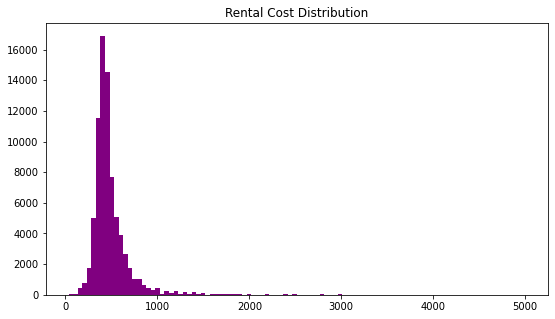

In [199]:
# Rental cost distribution
plt.figure(figsize = (9, 5))
plt.title("Rental Cost Distribution")
plt.hist(properties["Cost"], bins=100, color="purple")
plt.savefig("../plots/cost_distribution.jpg")
plt.show()

## Continuous Data Correlations
*Note:* We treat the ordinal features as continuous in order to keep ordering information.

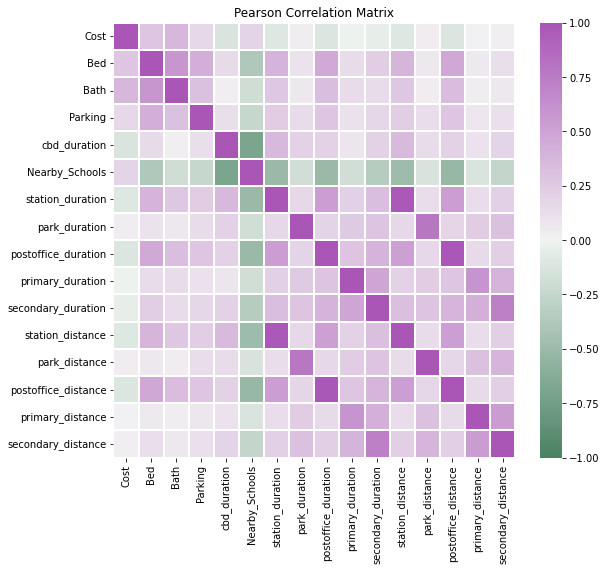

In [200]:
corrmat = properties.corr(method="pearson")
f, ax = plt.subplots(figsize =(9, 8))
colours = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# Possible colours: "coolwarm", "vlag"
sns.heatmap(corrmat, ax = ax, cmap=colours, linewidths = 0.1, center=0, vmin=-1)
plt.title("Pearson Correlation Matrix")
plt.savefig("../plots/correlation.jpg")
plt.show()

Find the most correlated features with rental cost of property.

In [201]:
sorted_mat = corrmat.unstack().sort_values()

# Reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:"correlation"}, axis=1, inplace=True)
df["Index"] = df.index
df = pd.concat(
        [df.drop("Index", axis=1), 
        df["Index"].apply(pd.Series)]
    , axis=1)

# Output correlation list
cost_correlations = pd.DataFrame(df[df[0] == "Cost"]["correlation"])
cost_correlations["abs_corr"] = abs(cost_correlations["correlation"])
cost_correlations.sort_values(by="abs_corr", ascending=False)

correlation  abs_corr
Cost Cost                    1.000000  1.000000
     Bath                    0.368456  0.368456
     Bed                     0.276056  0.276056
     Nearby_Schools          0.189412  0.189412
     Parking                 0.159231  0.159231
     cbd_duration           -0.125486  0.125486
     postoffice_duration    -0.116640  0.116640
     postoffice_distance    -0.111958  0.111958
     station_duration       -0.100943  0.100943
     station_distance       -0.094645  0.094645
     secondary_duration     -0.046353  0.046353
     park_distance           0.032768  0.032768
     park_duration           0.029983  0.029983
     secondary_distance      0.020004  0.020004
     primary_distance        0.009839  0.009839
     primary_duration       -0.008826  0.008826

## Continuous and Categorical Data Correlations

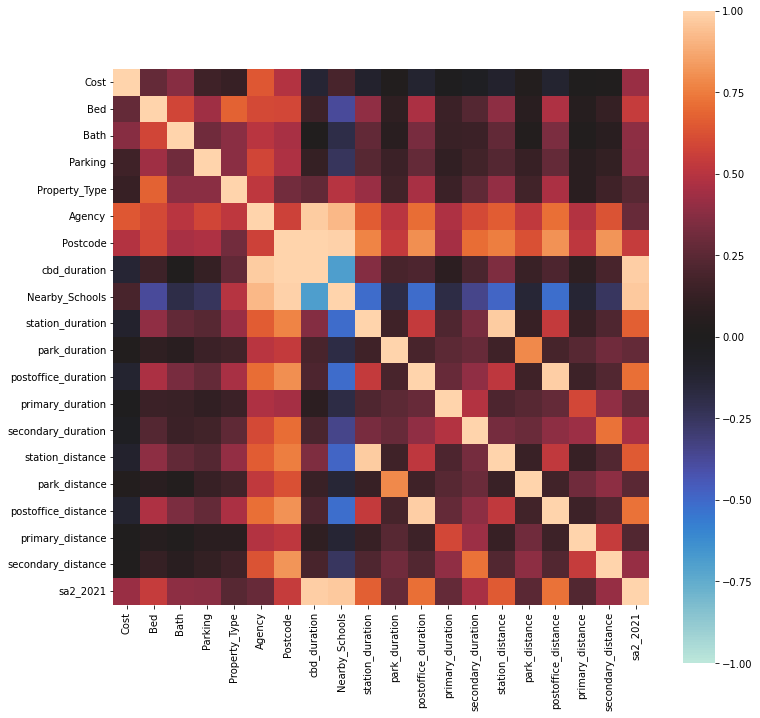

In [213]:
# Get initial correlation matrix
exclusions = ["Name", "Coordinates"]
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False, filename='../plots/corr_matrix.jpg', figsize=(12,12))

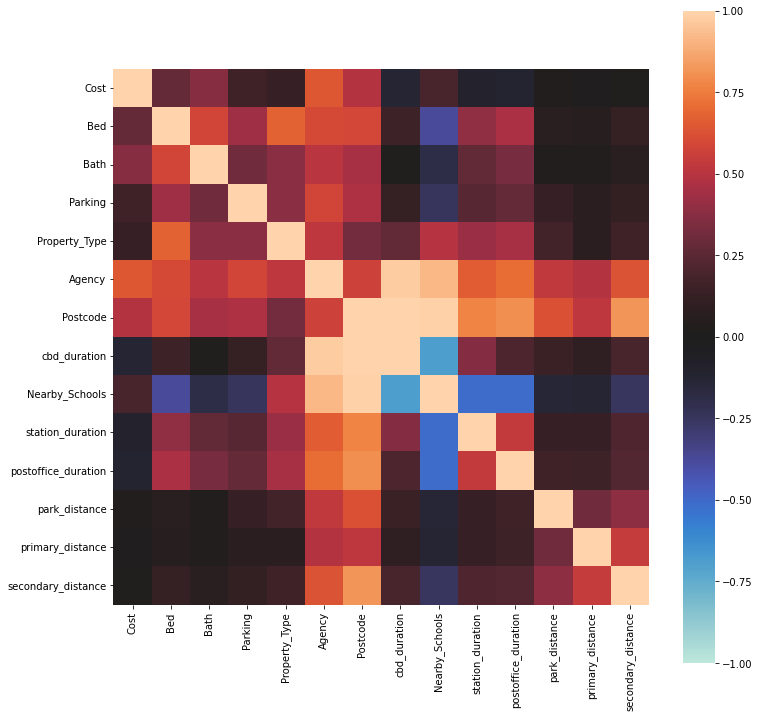

In [217]:
exclusions = ["Name", "Coordinates", "sa2_2021", "postoffice_distance", "station_distance", "park_duration", "secondary_duration", "primary_duration"]
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False, filename='../plots/corr_matrix_filtered.jpg', figsize=(12,12))

In [9]:
sorted_mat = corr_mat["corr"].unstack().sort_values()

# Reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:"correlation"}, axis=1, inplace=True)
df["Index"] = df.index
df = pd.concat(
        [df.drop("Index", axis=1), 
        df["Index"].apply(pd.Series)]
    , axis=1)

# Output correlation list
cost_correlations = pd.DataFrame(df[df[0] == "Cost"]["correlation"])
cost_correlations["abs_corr"] = abs(cost_correlations["correlation"])
cost_correlations = cost_correlations.sort_values(by="abs_corr", ascending=False)

# Remove multi-level indexing
cost_correlations.index = cost_correlations.index.droplevel(0)

cost_correlations.drop("Cost")

,correlation,abs_corr
Agency,0.647472,0.647472
Postcode,0.489504,0.489504
Bath,0.374861,0.374861
Bed,0.274215,0.274215
Nearby_Schools,0.189703,0.189703
Parking,0.158559,0.158559
Property_Type,0.131507,0.131507
CBD_Duration,-0.125417,0.125417
Post_Office_Duration,-0.116706,0.116706
Railway_Duration,-0.100313,0.100313


#### Highly correlated features
- Postcode and SA2 are extremely correlated, so only include postcode which has slightly higher correlation with cost. 
- all distance/duration combos - pick best from each category
    - keep duration: CBD, station
    - keep distance: park, secondary and primary schools (kids can"t drive and people likely want to walk to parks, not drive)
- Postcode highly correlated with everything
- cbd_duration: postcode and agency
- Median and total income - only include median
- median rent and mortgage payments - makes sense for landlords
- total household income and personal income - only keep household income

#### Interesting notes
- Highest correlations are for features already on property website - good, makes sense, they"re doing the right thing.
- people do not care about schools, if anything they don"t want to live near schools. Only a minority of people have children and care about that? People with and without kids cancel eachother out? Families less likely to rent than buy. 

## Categorical ANOVAs

In [10]:
# Test for relationship with categorical variables using one-way ANOVA
categoricals = ["Postcode", "Property_Type", "Agency"]

for c in categoricals:
    model = ols("Cost ~ "+c, data = properties).fit() # ordinary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq       mean_sq          F  PR(>F)
Postcode    408.0  1.089675e+09  2.670772e+06  59.972065     0.0
Residual  77648.0  3.457946e+09  4.453361e+04        NaN     NaN
                    df        sum_sq       mean_sq           F         PR(>F)
Property_Type      9.0  7.864734e+07  8.738594e+06  152.612462  1.508703e-287
Residual       78047.0  4.468973e+09  5.726003e+04         NaN            NaN


: 

: 

All p values are less than 0.05 so all attributes are significant.